In [1]:
from PIL import Image, ImageDraw
import numpy as np
import urllib
import json
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'matplotlib'

In [2]:
f = open('DistrictofColumbia.json', 'r')
json_dict = json.load(f)

lat_long_list_load = np.load('lat_long_list.npy')

meter_per_pixel = 100 / (np.sqrt(206**2 + 10**2))
lat_meter = 6378150*2*np.pi/(360)
long_meter = 6378150*np.cos(38.9/180*np.pi)*2*np.pi/(360)

In [3]:
def get_pixel(lat, long, center_lat, center_long,img_size=640,pad=0):
    lat_pix = int(img_size/2 -(lat-center_lat)*lat_meter/meter_per_pixel)
    long_pix = int(img_size/2 +(long-center_long)*long_meter/meter_per_pixel)
    return long_pix+pad,lat_pix+pad

In [18]:
len(json_dict["features"])

58330

# テスト

In [4]:
sample_coo = lat_long_list_load[1900]
sample_lat = float(sample_coo[:18])
sample_long = float(sample_coo[19:])
sample_lat,sample_long

(38.903828069631146, -77.04513910309363)

In [5]:
sample_buildings = []
margin = 320
for i in range(len(json_dict["features"])):
    coordinates = json_dict["features"][i]["geometry"]["coordinates"][0]
    flag = 0
    for coordinate in coordinates:
#         if coordinate==[-77.045013747486252,38.917497606245249]:
#             error
        long,lat = get_pixel(coordinate[1], coordinate[0], sample_lat, sample_long,img_size=640)
        if -margin< lat and lat<640+margin and -margin<long and long<640+margin:
            flag+=1
    if flag >= len(coordinates):
        sample_buildings.append(coordinates)
len(sample_buildings)

36

In [10]:
image = Image.new('P', (1280,1280),(0))
draw = ImageDraw.Draw(image)
for building in sample_buildings:
    pix_building = [get_pixel(long_lat[1],long_lat[0],sample_lat,sample_long,pad=320) for long_lat in building]
    draw.polygon(tuple(pix_building), fill=(255))
    draw.line(pix_building, fill=(255), width=3)
    for pix in pix_building:
        draw.ellipse((pix[0] - 1, pix[1] - 1, pix[0]  + 1, pix[1] + 1), fill=(255))
        
plt.imshow(np.asarray(image.convert('P'))[320:960,320:960])

NameError: name 'plt' is not defined

In [12]:
Image.fromarray(np.asarray(image)[320:960,320:960]).save("label.png")

(640, 640, 3)


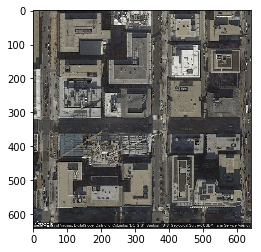

In [7]:
test_image = "/data/unagi0/takemoto/blogwatcher/pictures/columbia/"+str(lat_long_list_load[1900])+".png"
test_image = np.asarray(Image.open(test_image).convert('RGB'))
print(test_image.shape)
plt.imshow(np.array(test_image))

In [7]:
# Image.fromarray(test_image).save(str(lat_long_list_load[1900])+"_data.png")
# Image.fromarray(np.asarray(image)[320:960,320:960]).save(str(lat_long_list_load[1900])+"_label.png")

# データ作成

In [6]:
def create_label(filename,image_size=640):
    center_lat = float(filename[:filename.find(',')])
    center_long = float(filename[filename.find(',')+1:])
    contain_flag = False
    
    buildings = []
    margin = int(image_size/2)
    for i in range(len(json_dict["features"])):
        coordinates = json_dict["features"][i]["geometry"]["coordinates"][0]
        flag = 0
        for coordinate in coordinates:
            long,lat = get_pixel(coordinate[1], coordinate[0], center_lat, center_long,img_size=image_size)
            if -margin< lat and lat<image_size+margin and -margin<long and long<image_size+margin:
                flag+=1
        if flag >= len(coordinates):
            buildings.append(coordinates)
            contain_flag = True
            
#     image = Image.new('P', (image_size*2,image_size*2),(0)) # 画面外にはみ出る建物にも対応するため余白をとる
#     draw = ImageDraw.Draw(image)
#     for building in buildings:
#         pix_building = [get_pixel(long_lat[1],long_lat[0], center_lat, center_long,pad=margin) for long_lat in building]
#         draw.polygon(tuple(pix_building), fill=(18))
#         draw.line(pix_building, fill=(255), width=8)
#         for pix in pix_building:
#             draw.ellipse((pix[0] - 4, pix[1] - 4, pix[0]  + 4, pix[1] + 4), fill=(255))
            
#     Image.fromarray(np.asarray(image)[margin:margin+image_size,margin:margin+image_size]).save("/data/unagi0/takemoto/blogwatcher/labels/columbia/"+filename+".png")
    return contain_flag

In [7]:
lat_long_list_select = []
for file_name in list(lat_long_list_load):
    flag = create_label(file_name,image_size=640)
    if flag:
        lat_long_list_select.append(file_name)

In [8]:
len(lat_long_list_select)

1799

In [9]:
with open("../github/chainer_refinenet/train_select.txt", "w", encoding="utf-8") as f:
    f.write("\n".join(lat_long_list_select))